In [1]:
DATA_CSV = "../results/trajectories.csv"

GENERATE_DATA = False
# Parameters for generating data
MODEL_DIRECTORY = "../models/random_nk3"
UPDATE = "asynchronous"
N_RANDOM = 30 # number of random models
DEBUG = False
NSQUARE_STEPS = 20 # number of steps for nsquare

# Figure configuration
SUP_FIGURE_ID = "s8"
METRICS = ["rmsd"]
METHODS = None # plot all methods

FIGURE_DIR = "../results/figures"

In [2]:
import pandas as pd
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg

import sdmarkov.plotting.config as pc
from sdmarkov.transition_matrix import get_transition_matrix
from sdmarkov.graph import get_markov_chain
from sdmarkov.matrix_operations import compress_matrix
from sdmarkov.grouping import sd_grouping
from sdmarkov.paths import get_all_paths, get_markov_chain_path_probs, get_stg_path_probs, get_random_path_probs
from sdmarkov.paths import compare_path_reachability, compare_path_rmsd
from sdmarkov.attractors import get_predicted_attractors
from sdmarkov.analysis.utils import load_or_generate_data, add_classification_metrics, network_level_metrics_df
from sdmarkov.plotting.figures import plot_violin_figure, plot_distribution_figure, save_figure

In [3]:
def get_data_trajectories(
    bnet,
    bnet_name=None,
    update="asynchronous",
    n_random=30,
    DEBUG=False,
):
    """
    Compare trajectory/path-level properties between the STG
    and grouped Markov-chain representations.

    Returns
    -------
    pd.DataFrame
        Long-format table with columns:
        bnet, method, run, paths_reachability, paths_rmsd
    """

    rows = []

    primes = bnet_text2primes(bnet)
    primes = {k: primes[k] for k in sorted(primes)}

    # Percolate constant nodes
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return pd.DataFrame(rows)

    percolated_bnet = primes2bnet(percolated_primes)
    n_states = 2 ** len(percolated_primes)
    stg = primes2stg(percolated_primes, update)

    # --- full transition matrix ---
    T = get_transition_matrix(stg, DEBUG=DEBUG)

    # --- SD grouped transition matrix ---
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)

    # Predicted attractors
    predicted_attractor_indices = get_predicted_attractors(Tsd, sd_indices, as_indices=True, DEBUG=DEBUG)
    n_attractors = len(predicted_attractor_indices)

    sd_mc = get_markov_chain(Tsd, sd_indices, DEBUG=DEBUG)
    sd_all_paths = get_all_paths(sd_mc, DEBUG=DEBUG)

    sd_mc_path_probs = get_markov_chain_path_probs(sd_mc, sd_all_paths, DEBUG=DEBUG)
    sd_stg_path_probs = get_stg_path_probs(sd_all_paths, sd_indices, stg, T, DEBUG=DEBUG)

    # --- helper: add row ---
    def add_row(method, stg_probs, predictions, run=None):
        TP, FP, TN, FN = compare_path_reachability(stg_probs, predictions, type="non_edges", DEBUG=DEBUG)
        rmsd_val = compare_path_rmsd(stg_probs, predictions, type="non_edges", DEBUG=DEBUG)
        rows.append({
            "bnet": bnet_name,
            "method": method,
            "run": run,
            "rmsd": rmsd_val,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "n_states": n_states,
            "n_attractors": n_attractors,
            "update_scheme": update
        })

    # --- deterministic SD method ---
    add_row("sd_mc", sd_stg_path_probs, sd_mc_path_probs)

    # --- randomized baselines ---
    for i in range(n_random):
        random_path_probs = get_random_path_probs(sd_mc_path_probs, seed=i)
        add_row("ref", sd_stg_path_probs, random_path_probs, run=i)

    return pd.DataFrame(rows)

In [4]:
df = load_or_generate_data(
    data_csv=DATA_CSV,
    generate_data=GENERATE_DATA,
    data_function=get_data_trajectories,
    model_directory=MODEL_DIRECTORY,
    update=UPDATE,
    n_random=N_RANDOM,
    debug=DEBUG,
)

Loaded cached results from ../results/trajectories.csv.


In [5]:
print("Preview of results DataFrame:")
display(df.head())

print("\nDataFrame shape:", df.shape)
print("Methods present:", df.method.unique())
print("Number of unique networks:", df.bnet.nunique())

Preview of results DataFrame:


,bnet,method,run,rmsd,TP,FP,TN,FN,n_states,n_attractors,update_scheme
0,n010_000.bnet,sd_mc,NaN,0.043222,96,0,0,0,1024,2,asynchronous
1,n010_000.bnet,ref,0.0,0.171892,96,0,0,0,1024,2,asynchronous
2,n010_000.bnet,ref,1.0,0.245305,96,0,0,0,1024,2,asynchronous
3,n010_000.bnet,ref,2.0,0.145318,96,0,0,0,1024,2,asynchronous
4,n010_000.bnet,ref,3.0,0.165921,96,0,0,0,1024,2,asynchronous



DataFrame shape: (2821, 11)
Methods present: ['sd_mc' 'ref']
Number of unique networks: 91


## Data analysis

In [6]:
# filter models with TP+FP > 0
df = df[(df.TP + df.FP) > 0]

# add precision, recall, specificity, and NPV
df = add_classification_metrics(df)

print("Added classification metrics")
print("DataFrame shape:", df.shape)
print("Methods present:", df.method.unique())
print("Number of unique networks:", df.bnet.nunique())

display(df.head())

Added classification metrics
DataFrame shape: (2108, 15)
Methods present: ['sd_mc' 'ref']
Number of unique networks: 68


,bnet,method,run,rmsd,TP,FP,TN,FN,n_states,n_attractors,update_scheme,precision,recall,specificity,npv
0,n010_000.bnet,sd_mc,NaN,0.043222,96,0,0,0,1024,2,asynchronous,1.0,1.0,NaN,NaN
1,n010_000.bnet,ref,0.0,0.171892,96,0,0,0,1024,2,asynchronous,1.0,1.0,NaN,NaN
2,n010_000.bnet,ref,1.0,0.245305,96,0,0,0,1024,2,asynchronous,1.0,1.0,NaN,NaN
3,n010_000.bnet,ref,2.0,0.145318,96,0,0,0,1024,2,asynchronous,1.0,1.0,NaN,NaN
4,n010_000.bnet,ref,3.0,0.165921,96,0,0,0,1024,2,asynchronous,1.0,1.0,NaN,NaN


In [7]:
df_metrics = network_level_metrics_df(df=df)

print("Preview of network-level metrics DataFrame:")
display(df_metrics.head())

print("\nDataFrame shape:", df_metrics.shape)
print("Methods present:", df_metrics.method.unique())
print("Number of unique networks:", df_metrics.bnet.nunique())

print("\nNetwork-level classification metrics:")
metrics = ["rmsd", "precision", "recall", "specificity", "npv"]
summary = (
    df_metrics
    .groupby("method")[metrics]
    .agg(["mean", "min", "median", "max"])
)

display(summary)

Preview of network-level metrics DataFrame:


,bnet,method,rmsd,TP,FP,TN,FN,n_states,n_attractors,update_scheme,precision,recall,specificity,npv
0,n010_000.bnet,ref,0.171892,96.0,0.0,0.0,0.0,1024.0,2.0,asynchronous,1.0,1.0,NaN,NaN
1,n010_000.bnet,ref,0.245305,96.0,0.0,0.0,0.0,1024.0,2.0,asynchronous,1.0,1.0,NaN,NaN
2,n010_000.bnet,ref,0.145318,96.0,0.0,0.0,0.0,1024.0,2.0,asynchronous,1.0,1.0,NaN,NaN
3,n010_000.bnet,ref,0.165921,96.0,0.0,0.0,0.0,1024.0,2.0,asynchronous,1.0,1.0,NaN,NaN
4,n010_000.bnet,ref,0.166350,96.0,0.0,0.0,0.0,1024.0,2.0,asynchronous,1.0,1.0,NaN,NaN



DataFrame shape: (2108, 14)
Methods present: ['ref' 'sd_mc']
Number of unique networks: 68

Network-level classification metrics:


rmsd                                   precision                   \
            mean           min    median       max      mean       min median   
method                                                                          
ref     0.191416  0.000000e+00  0.149009  0.985290  0.999677  0.978056    1.0   
sd_mc   0.075496  4.440892e-16  0.065934  0.333333  0.999677  0.978056    1.0   

            recall                  specificity                   npv      \
        max   mean  min median  max        mean  min median  max mean min   
method                                                                      
ref     1.0    1.0  1.0    1.0  1.0         0.0  0.0    0.0  0.0  NaN NaN   
sd_mc   1.0    1.0  1.0    1.0  1.0         0.0  0.0    0.0  0.0  NaN NaN   

                   
       median max  
method             
ref       NaN NaN  
sd_mc     NaN NaN

## Plotting

In [8]:
pc.apply_style()

PosixPath('../results/figures/Figure_s8_Trajectory_probabilities.png')

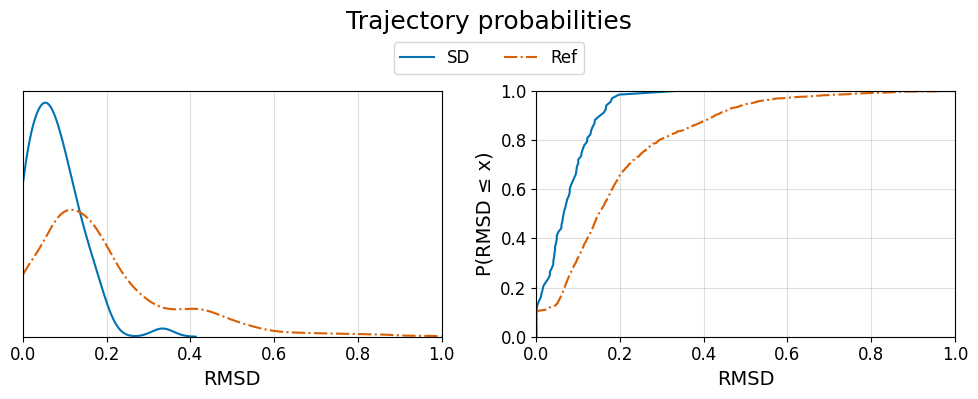

In [9]:
fig = plot_distribution_figure(df_metrics, metrics=METRICS, figure_id=SUP_FIGURE_ID, legend_loc=0.94)

save_figure(fig, figure_id=SUP_FIGURE_ID, outdir=FIGURE_DIR)